##**Loading dataset from kaggle :**

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 96% 143M/149M [00:00<00:00, 1.47GB/s]
100% 149M/149M [00:00<00:00, 1.43GB/s]


In [ ]:
!unzip -q *.zip


****

In [ ]:
!mkdir -p brain_tumor_dataset
!mv Testing  brain_tumor_dataset/
!mv Training  brain_tumor_dataset/

##**Loading and pre-processing data :**

In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


**calculating 'mean' and 'std' of dataset**

In [ ]:
# temporary transform: only convert to tensor
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
dataset = datasets.ImageFolder("/content/brain_tumor_dataset/Training", transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=0)

mean = 0.
std = 0.
for images, _ in loader:
    batch_samples = images.size(0)  # batch size (the last batch can be smaller)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(dataset)
std /= len(dataset)

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.1855, 0.1855, 0.1855])
Std: tensor([0.1813, 0.1813, 0.1813])


**Pipeline for Preprocessing + Augmentation**

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1855, 0.1855, 0.1855],
                         std=[0.1813, 0.1813, 0.1813])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1855, 0.1855, 0.1855],
                         std=[0.1813, 0.1813, 0.1813])
])



**Load dataset**

In [ ]:
train_dir = '/content/brain_tumor_dataset/Training'
test_dir = '/content/brain_tumor_dataset/Testing'

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)


**Spliting dataset**

In [ ]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])


**Create dataloader**

In [ ]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

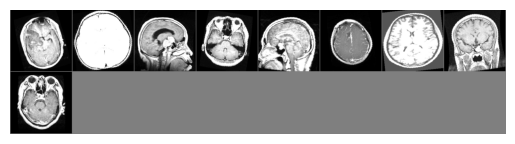

Labels: ['glioma', 'notumor', 'meningioma', 'pituitary', 'pituitary', 'glioma', 'notumor', 'pituitary', 'pituitary']


In [ ]:
import torchvision
import numpy as np

classes = train_dataset.classes  # ['glioma', 'meningioma', 'no_tumor', 'pituitary']

def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title: plt.title(title)
    plt.axis('off')
    plt.show()

# Get a batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:9]))
print('Labels:', [classes[i] for i in labels[:9]])


**CNN model**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.drop2 = nn.Dropout(0.4)

        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.drop2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.drop1(x)
        x = self.fc2(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_classes = len(train_dataset.classes)
model = BrainTumorCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Using device: cuda


In [ ]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        val_acc = evaluate(model, val_loader)

        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch [1/10] | Loss: 0.5249 | Train Acc: 80.41% | Val Acc: 81.89%
Epoch [2/10] | Loss: 0.3375 | Train Acc: 87.44% | Val Acc: 85.21%
Epoch [3/10] | Loss: 0.2801 | Train Acc: 89.71% | Val Acc: 73.58%
Epoch [4/10] | Loss: 0.2587 | Train Acc: 90.76% | Val Acc: 86.88%
Epoch [5/10] | Loss: 0.2036 | Train Acc: 92.62% | Val Acc: 91.34%
Epoch [6/10] | Loss: 0.1639 | Train Acc: 94.07% | Val Acc: 87.58%
Epoch [7/10] | Loss: 0.1589 | Train Acc: 94.24% | Val Acc: 90.73%
Epoch [8/10] | Loss: 0.1443 | Train Acc: 94.66% | Val Acc: 94.49%
Epoch [9/10] | Loss: 0.1206 | Train Acc: 95.73% | Val Acc: 95.36%
Epoch [10/10] | Loss: 0.1063 | Train Acc: 96.43% | Val Acc: 94.14%


In [ ]:
test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 94.28%


##**Using transfer learning**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


**Load pre-trained model (Resnet18)**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

num_classes = len(train_dataset.classes)

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False   # Freeze feature extractor

# Replace the final layer
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes)
)

model = model.to(device)


Using: cuda


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        val_acc = evaluate(model, val_loader)
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


In [ ]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total


In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

Epoch [1/5] | Loss: 0.6113 | Train Acc: 76.25% | Val Acc: 82.59%
Epoch [2/5] | Loss: 0.4334 | Train Acc: 83.50% | Val Acc: 84.16%
Epoch [3/5] | Loss: 0.3977 | Train Acc: 85.27% | Val Acc: 86.96%
Epoch [4/5] | Loss: 0.3599 | Train Acc: 85.86% | Val Acc: 88.36%
Epoch [5/5] | Loss: 0.3512 | Train Acc: 86.47% | Val Acc: 88.28%


In [ ]:
test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 86.58%
